# Clean dataset using influence functions and neural networks

A dataset usually consists of a lot of data points, while not all data points are equally important for achieving the desired accuracy. Sometimes it is necessary to speed up the gradient calculations or optimize the required RAM. Example applications are reinforcement learning or continuous optimal control tasks. This notebook

- shows how to calculate influences using the pyDVL library of an arbitrary (usually called training) set of data samples $X_\text{train} \subseteq \mathbb{R}^d$ onto a test set $X_\text{test} \subseteq \mathbb{R}^d$.
- shows a plot with the weighted F1-score on the y-axis and the number of samples on the x-axis.
- selects the optimal number of samples for the dataset as induced by the influence functions.

First, an arbitrary random dataset can be loaded or created using the ```utils.dataset.Dataset``` class. For showcase purposes

In [1]:
from sklearn.datasets import load_wine
from valuation.utils.dataset import Dataset

wine_bunch = load_wine(as_frame=True)
dataset = Dataset.from_sklearn(wine_bunch)

the wine dataset is used. It can be loaded (as any other compatible dataset) directly from sklearn.

## Visualizing the multi-dimensional data using a TSNE embedding and class colors

As usual a closer inspection of the data is helpful. Hence, the data is plotted by first encoding it using a TSNE embedding. This can be achieved by the following function.

/home/runner/work/valuation/valuation/.tox/test-notebooks/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


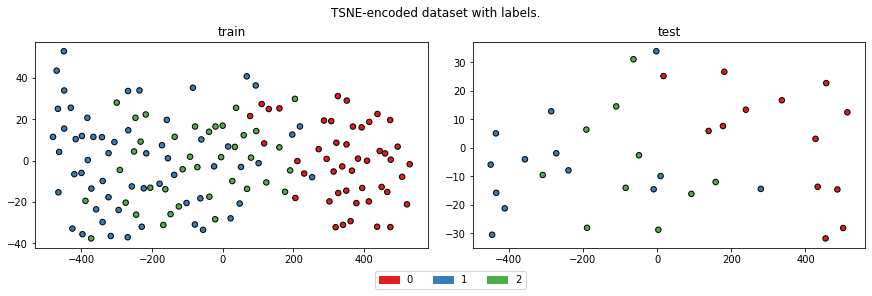

In [2]:
from valuation.utils import dataset_tsne_encode, dataset_to_json
from valuation.utils.plotting import plot_datasets

tsne_dataset = dataset_tsne_encode(dataset)
tsne_dateset_json = dataset_to_json(tsne_dataset)
plot_datasets(tsne_dateset_json, s=30, suptitle="TSNE-encoded dataset with labels.")

## Fit a neural network to the data

First, a 2-layer neural network is created and fitted with pyDVL. This can be achieved by the following

In [3]:
from copy import copy
import torch
from valuation.models import TorchModule, TorchOptimizer, NeuralNetworkTorchModel, TorchObjective
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import numpy as np

x_transformer = MinMaxScaler()

transformed_dataset = copy(dataset)
transformed_dataset.x_train = x_transformer.fit_transform(transformed_dataset.x_train)
transformed_dataset.x_test = x_transformer.transform(transformed_dataset.x_test)
feature_dimension = transformed_dataset.x_train.shape[1]
unique_classes = np.unique(np.concatenate((dataset.y_train, dataset.y_test)))
num_classes = len(unique_classes)

network_size = [16, 16]
model = TorchModule(
    model=NeuralNetworkTorchModel(feature_dimension, num_classes, network_size),
    objective=TorchObjective(F.cross_entropy, "long"),
    num_epochs=300,
    batch_size=32,
    optimizer=TorchOptimizer.ADAM,
    optimizer_kwargs={
        "lr": 0.001,
        "weight_decay": 0.001,
        "cosine_annealing": True,
    }
)
model.fit(
    transformed_dataset.x_train,
    transformed_dataset.y_train
)

code snippet. It creates a 2-layer neural network with 16 neurons in each hidden layer. After fitting the data, the TSNE embedded data along with the predicted values get displayed.

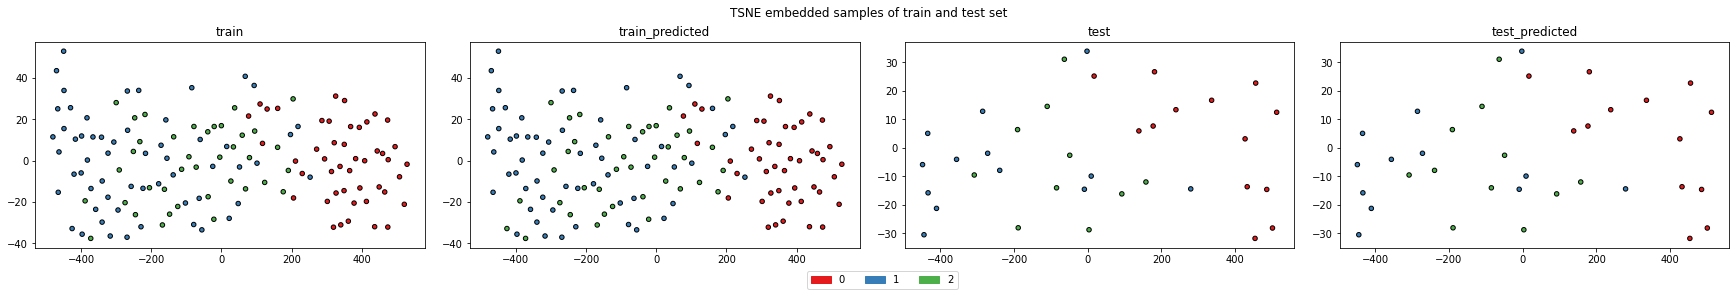

In [4]:
import numpy as np

pred_y_train = np.argmax(model.predict(transformed_dataset.x_train), axis=1)
pred_y_test = np.argmax(model.predict(transformed_dataset.x_test), axis=1)

datasets = {
    'train': (tsne_dataset.x_train, dataset.y_train),
    'train_predicted': (tsne_dataset.x_train, pred_y_train),
    'test': (tsne_dataset.x_test, dataset.y_test),
    'test_predicted': (tsne_dataset.x_test, pred_y_test)
}
plot_datasets(datasets, s=20, suptitle="TSNE embedded samples of train and test set")

A short visual inspection yields that all labels of the test set are now classified correctly. This can be verified by

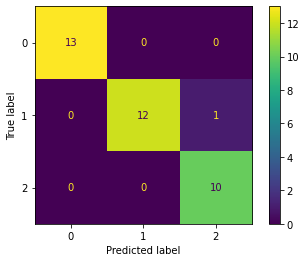

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(dataset.y_test, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plotting a confusion matrix using ```sklearn``` library. As one can see the accuracy is 100% for the selected model.

## Calculating influences for small neural networks

The following section elaborates the calculation of influences through a neural network. It is noteworthy that the full Hessian matrix is constructed and used for inverting the gradients. This can only be achieved for small networks. In the case of a big network additionally conjugate gradient has to be used to perform approximate inversion. The influences for both the train and test set are calculated

In [6]:
from valuation.influence.general import influences

inversion_method = "direct" # cg for big networks
test_influences = influences(model, transformed_dataset.x_test, transformed_dataset.y_test, inversion_method=inversion_method)
train_influences = influences(model, transformed_dataset.x_train, transformed_dataset.y_train, transformed_dataset.x_test, transformed_dataset.y_test, inversion_method=inversion_method)

by the preceding code snippet. Subsequently, the mean absolute influence of one train sample onto all test samples is calculated by

In [7]:
mean_influences = lambda arr: np.mean(np.abs(arr), axis=0)
mean_train_influences = mean_influences(train_influences)
mean_test_influences = mean_influences(test_influences)

and plotted by

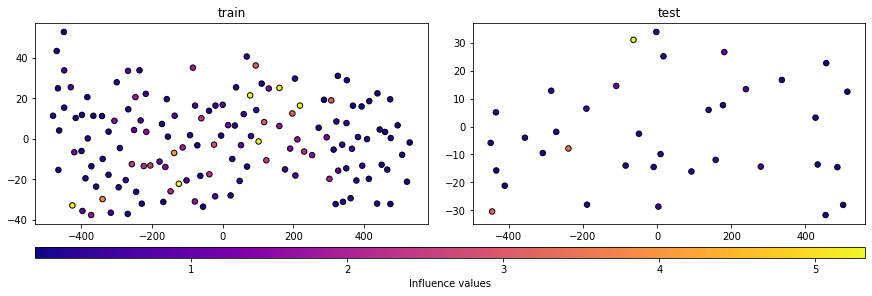

In [8]:
influence_datasets = {
    'train': (tsne_dataset.x_train, mean_train_influences),
    'test': (tsne_dataset.x_test, mean_test_influences),
}
plot_datasets(influence_datasets, s=30)

a visual inspection yields that there are indeed different influential samples.

## Keeping the most influential samples

Using the pyDVL library, the next section selects the most influential samples and retrains the model using the shortened dataset. This is done over the number of samples to showcase how the weighted F1-score changes.

In [9]:
from IPython.core.display_functions import display
from sklearn.metrics import f1_score
import pandas as pd

num_estimates_per_samples = 5
min_num_samples = 1
metrics = {}
x_range = range(min_num_samples, len(dataset), 5)

for i, num_shortened_samples in enumerate(x_range):
    display(f"Iteration {i+1}/{len(x_range)}")
    summed_metric = 0

    for j in range(num_estimates_per_samples):
        idx = np.flip(np.argsort(mean_train_influences))[:num_shortened_samples]
        shortened_dataset = copy(transformed_dataset)
        shortened_dataset.x_train = shortened_dataset.x_train[idx]
        shortened_dataset.y_train = shortened_dataset.y_train[idx]
        shortened_model = TorchModule(
            model=NeuralNetworkTorchModel(feature_dimension, num_classes, network_size),
            objective=TorchObjective(F.cross_entropy, "long"),
            num_epochs=300,
            batch_size=32,
            optimizer=TorchOptimizer.ADAM,
            optimizer_kwargs={
                "lr": 0.001,
                "weight_decay": 0.001,
                "cosine_annealing": True,
            }
        )
        shortened_model.fit(
            shortened_dataset.x_train,
            shortened_dataset.y_train
        )
        pred_y_test = np.argmax(shortened_model.predict(transformed_dataset.x_test), axis=1)
        summed_metric += f1_score(shortened_dataset.y_test, pred_y_test, average="weighted")

    metrics[num_shortened_samples] = summed_metric / num_estimates_per_samples

metrics = pd.Series(metrics)

'Iteration 1/29'

'Iteration 2/29'

'Iteration 3/29'

'Iteration 4/29'

'Iteration 5/29'

'Iteration 6/29'

'Iteration 7/29'

'Iteration 8/29'

'Iteration 9/29'

'Iteration 10/29'

'Iteration 11/29'

'Iteration 12/29'

'Iteration 13/29'

'Iteration 14/29'

'Iteration 15/29'

'Iteration 16/29'

'Iteration 17/29'

'Iteration 18/29'

'Iteration 19/29'

'Iteration 20/29'

'Iteration 21/29'

'Iteration 22/29'

'Iteration 23/29'

'Iteration 24/29'

'Iteration 25/29'

'Iteration 26/29'

'Iteration 27/29'

'Iteration 28/29'

'Iteration 29/29'

Note, how the model is created completely new and is not derived from the previous model. This section showcases how to use the influence calculations The notebook finishes by plotting

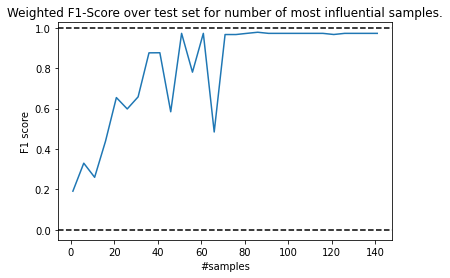

In [10]:
import matplotlib.pyplot as plt

plt.figure()
metrics.plot(xlabel="#samples", ylabel="F1 score", title="Weighted F1-Score over test set for number of most influential samples.")
hline_kwargs = {
    "linestyle": "--",
    "color": "black"
}
plt.axhline(0.0, **hline_kwargs)
plt.axhline(1.0, **hline_kwargs)
plt.show()

the optimal number of samples on the x-axis along with the weighted F1-score on the y-axis.

In [11]:
optimal_number_of_samples = metrics.index[metrics.argmax()]
f"The optimal number of samples is {optimal_number_of_samples}"

'The optimal number of samples is 86'

Over multiple runs with different the optimal number of samples canges, but it can be said to be safe to remove around 30% of the samples of the wine dataset to easily achieve the same data accuracy.